### 2018/2019 - Task List 11

1. Utilize pyro Latent Dirichlet Allocation community implementation to perform experiments with text and provide insights from the results:
    - https://ws.clarin-pl.eu/public/teksty/2mini.zip
    - https://ws.clarin-pl.eu/public/teksty/2autorow.zip    
    - https://ws.clarin-pl.eu/public/teksty/5_autorow_skrot.zip
2. Compare the obtained results with another implementation of LDA.

REMARK! Please do not care about linguistic issues (lematization, disambiguation, etc.)

# Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TraceEnum_ELBO, TracePredictive, config_enumerate
import csv
import os
import string

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

In [3]:
def create_vocabulary(documents):
    vocabulary = []
    for doc in documents:
        for word in doc:
            if word not in vocabulary:
                vocabulary.append(word)
    return vocabulary

def plot_losses(losses):
    plt.plot(losses)
    plt.title("evidence lower bound (ELBO)")
    plt.xlabel("step")
    plt.ylabel("loss");

In [4]:
from stop_words import get_stop_words
stop_words = get_stop_words('polish')
stop_words.extend(["ale"])
# print(stop_words)

In [5]:
"""
K = number of topics
V = number of words
M = number of documents
N = number of words per document
"""

def model(docs_indices):
    beta = torch.ones(K, V) * beta_value
    with pyro.plate("K", K):
        phi = pyro.sample("phi", dist.Dirichlet(beta))

    alpha = torch.ones(M, K) * alpha_value
    with pyro.plate("M", M):
        theta = pyro.sample("theta", dist.Dirichlet(alpha))

        with pyro.plate("N", N):
            z = pyro.sample("z", dist.Categorical(theta))
            w = pyro.sample("w", dist.Categorical(phi[z]), obs=docs_indices)
            return w


def guide(docs_indices):
    beta = pyro.param("beta", torch.ones(K, V) * beta_value, constraint=constraints.positive)
    with pyro.plate("K", K):
        phi = pyro.sample("phi", dist.Dirichlet(beta))

    alpha = pyro.param("alpha", torch.ones(M, K) * alpha_value, constraint=constraints.positive)
    with pyro.plate("M", M):
        theta = pyro.sample("theta", dist.Dirichlet(alpha))
        with pyro.plate("N", N):
            z = pyro.sample("z", dist.Categorical(theta))

In [6]:
def read_files(file_dir):
    real_documents = []
    lengths = []
    vocabulary = []

    for file in os.listdir(file_dir):
        file_path = os.path.join(file_dir, file)
        with open(file_path, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ')
            text = []
            for row in reader:
                row = [''.join(c for c in s if c not in string.punctuation) for s in row]
                row = [s.lower() for s in row]
                text.extend(row)
            text = [word for word in text if len(word) > 2]
            text = [word for word in text if word not in stop_words]
            vocab = [word for word in text if word not in vocabulary]
            vocab = list(dict.fromkeys(vocab))
            vocabulary.extend(vocab)
            real_documents.append(text)
            lengths.append(len(text))
            print("document {} loaded, length: {}, vocab: {}".format(file_path, len(text), len(vocabulary)))

    print("docs ", len(real_documents))

    # vocabulary = create_vocabulary(real_documents)
    min_length = min(lengths)
    # min_length = 300
    print("Min length: ", min_length)
    print("Max length: ", max(lengths))
    truncated_documents = []
    for document in real_documents:
        if len(document) > min_length:
            truncated_documents.append(document[:min_length])
    #         real_documents.append(document[min_length:])
        elif len(document) < min_length:
            pass
        else:
            truncated_documents.append(document)
    # print(truncated_documents)

    vocabulary = create_vocabulary(truncated_documents)

    print("Words ", len(vocabulary))
    print("Documents: ", len(truncated_documents))
    return truncated_documents, vocabulary

In [7]:
%%time

file_dir = "test_dir"
truncated_documents, vocabulary = read_files(file_dir)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

documents = [[ word2idx[word] for word in d] for d in truncated_documents]

document test_dir\test.txt loaded, length: 116, vocab: 12
document test_dir\test2.txt loaded, length: 102, vocab: 20
document test_dir\test3.txt loaded, length: 156, vocab: 26
document test_dir\test4.txt loaded, length: 150, vocab: 26
document test_dir\test5.txt loaded, length: 138, vocab: 32
docs  5
Min length:  102
Max length:  156
Words  32
Documents:  5
Wall time: 238 ms


In [8]:
# print(vocabulary)

In [9]:
K = 3  # number of topics
V = len(vocabulary)  # number of words
M = len(documents)  # number of documents
N = len(documents[0])  # number of words per document

print("Topics: {}, Words: {}, Documents: {}, Words per doc: {}".format(K, V, M, N))

Topics: 3, Words: 32, Documents: 5, Words per doc: 102


In [10]:
%%time

alpha_value = 0.3
beta_value = 0.3

pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, config_enumerate(guide, 'parallel'), optimizer, loss=TraceEnum_ELBO())

n_steps = 10000
# do gradient steps
t = tqdm(range(n_steps))
losses = []
for step in t:
    loss = svi.step(torch.IntTensor(np.transpose(documents)))
    losses.append(loss)
    t.set_postfix(loss=loss)


Wall time: 3min 48s


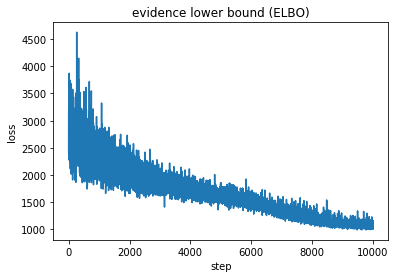

In [11]:
plot_losses(losses)

In [12]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

beta tensor([[ 0.5936,  1.9579,  1.1213, 43.6754, 27.6343,  0.2793,  0.4012,  1.3247,
          1.3054,  0.3978,  0.4257,  0.3014,  0.5145,  0.5623,  0.2160,  0.2087,
          0.2132,  0.2127,  0.2711,  0.2422,  0.9417,  1.2717,  1.2482,  1.2555,
          1.2892,  1.2781,  0.2421,  0.2244,  0.2657,  0.2221,  0.2543,  0.2029],
        [ 6.1812, 28.4817,  7.9121,  3.7223,  3.5900,  0.8112,  2.9523,  0.8882,
          0.8987,  3.0151,  3.2531,  0.8882,  0.6255,  0.6687,  0.2241,  0.2246,
          0.2239,  0.2207,  0.3232,  0.2821,  0.2106,  0.2208,  0.2209,  0.2221,
          0.2192,  0.2267,  1.1744,  0.9051,  1.4677,  0.8903,  1.1580,  0.5699],
        [ 0.4678,  1.2422,  0.6930,  2.6885,  1.9088,  0.2464,  0.3279,  0.3392,
          0.3312,  0.3272,  0.3432,  1.6348, 16.9873, 19.4066,  1.5955,  1.5364,
          1.5411,  1.6164,  4.3649,  2.9729,  0.2646,  0.3100,  0.2938,  0.3018,
          0.3049,  0.3125,  0.2356,  0.2327,  0.2498,  0.2173,  0.2442,  0.2145]],
       grad_fn=<Add

In [13]:
params = pyro.get_param_store()

beta = params["beta"]
phi = pyro.sample("phi", dist.Dirichlet(beta)).detach().numpy()

alpha = params["alpha"]
theta = pyro.sample("theta", dist.Dirichlet(alpha)).detach().numpy()
print(phi)
print(theta)

[[2.27335445e-03 3.64376865e-02 1.57189537e-02 5.29623270e-01
  2.64781922e-01 4.66590514e-04 5.69629716e-03 3.86269134e-03
  2.66754553e-02 6.59797050e-04 1.33405803e-02 3.63531959e-04
  7.29448802e-05 7.66214402e-03 1.48799945e-05 1.48122269e-03
  2.81641235e-07 8.36079926e-05 1.26672573e-02 4.29745647e-04
  1.52751068e-02 1.13804042e-02 1.06706051e-02 7.28756143e-03
  1.46750975e-02 1.58033203e-02 1.19208998e-07 2.38916109e-04
  4.22912766e-04 1.92917942e-03 4.60809588e-06 1.19208998e-07]
 [1.26052544e-01 2.98635870e-01 1.24627575e-01 2.89615840e-02
  1.49589032e-02 1.73167493e-02 4.84261103e-02 1.01672402e-02
  8.35011364e-04 4.75478619e-02 4.73683141e-02 3.59296042e-04
  1.59830274e-03 2.68195458e-02 3.86337888e-07 1.58947462e-03
  5.96134749e-04 6.86336076e-03 3.53433937e-02 8.97211663e-04
  1.55439593e-05 3.34632467e-03 1.19208998e-07 8.13556596e-07
  3.75606283e-03 9.04686842e-03 7.17323571e-02 7.27710954e-04
  7.34927226e-03 5.51224090e-02 9.89150349e-03 4.63651559e-05]
 [1.44

In [14]:
# print(vocabulary)
# print([[idx2word[word] for word in words[:3] ]for words in reversed(np.argsort(phi, axis=1))])

In [15]:
for i in range(0, len(truncated_documents)):
    print(f"d_{i}", truncated_documents[i])

d_0 ['leki', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'lekarz', 'lekarz', 'weterynarz', 'weterynarze', 'lekarze', 'psy', 'koty', 'leki', 'przeciwbólowe', 'medycyna', 'lekarz', 'lekarz', 'weterynarz', 'ludzie', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'lekarz', 'lekarz', 'weterynarz', 'medycyna', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'leki', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'lekarz', 'lekarz', 'weterynarz', 'weterynarze', 'lekarze', 'psy', 'koty', 'leki', 'przeciwbólowe', 'medycyna', 'lekarz', 'lekarz', 'weterynarz', 'ludzie', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz',

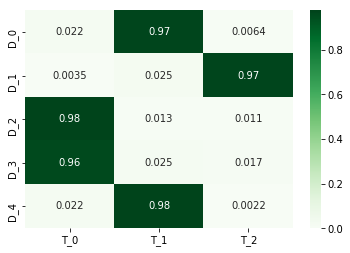

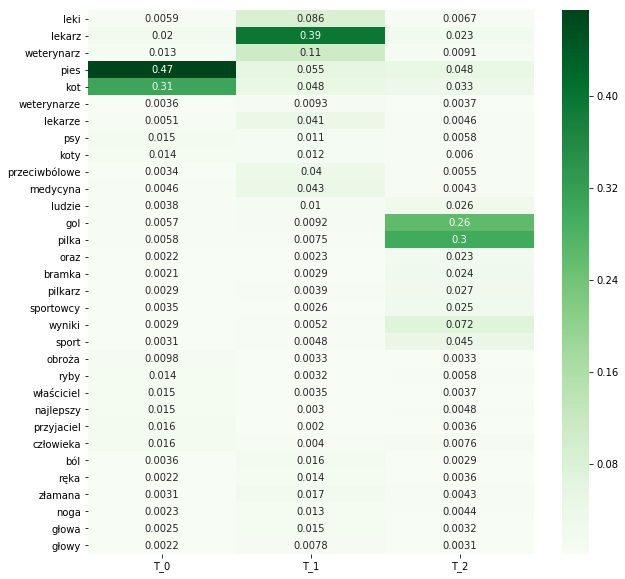

In [17]:
def plot_heatmap_docs_topics(theta):
    Index= [f'D_{i}' for i in range(0, M)]
    Cols = [f'T_{i}' for i in range(0, K)]
    df = pd.DataFrame(theta, index=Index, columns=Cols)

    plt.figure() # figsize=(10,5)
    sns.heatmap(df, annot=True, cmap="Greens")
    
    
def plot_heatmap_words_topisc(phi):
    Index = [idx2word[i] for i in range(0, V)]
    Cols = [f'T_{i}' for i in range(0, K)]
    df = pd.DataFrame(np.transpose(phi), index=Index, columns=Cols)

    plt.figure(figsize=(10,10)) # figsize=(10,5)
    sns.heatmap(df, annot=True, cmap="Greens")


num_repeats = 100

beta = params["beta"]
# phi = pyro.sample("phi", dist.Dirichlet(beta)).detach().numpy()
phis = [pyro.sample("phi", dist.Dirichlet(beta)).detach().numpy() for i in range(num_repeats)]
phi = np.mean( np.array(phis), axis=0 )

alpha = params["alpha"]
# theta = pyro.sample("theta", dist.Dirichlet(alpha)).detach().numpy()
thetas = [pyro.sample("theta", dist.Dirichlet(alpha)).detach().numpy() for i in range(num_repeats)]
theta = np.mean( np.array(thetas), axis=0 )

plot_heatmap_docs_topics(theta)
plot_heatmap_words_topisc(phi)